In [1]:
import sys
import warnings
from distutils.version import LooseVersion

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import network
import utils

%matplotlib inline

In [108]:
tf.reset_default_graph()

cp_dir = '/Users/cjw/Projects/cjw/Gerton/tpo/checkpoints/'
width = 64
height = 64
nchannels = 1
channels = [2]
#nepochs = params['nepochs']
batchsize = 32
learning_rate = 0.00005
#restore = params['restore']
latent_size = 192
enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, height, width, nchannels))
z = tf.placeholder(tf.float32, (None, latent_size))

enc = network.encoder(images, latent_size, droprate=.7, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=nchannels, width=width, droprate=.7,
                      is_train=False, nfilters=dec_sizes)

loss = network.ae_loss(images, sdd, nchannels=nchannels,
                       latent_size=latent_size, width=width)

opt = network.model_opt(loss, learning_rate)

saver = tf.train.Saver()
# test_batch, _, _ = utils.getbatch(mmdict, df, len(df) // batchsize,
#                                   batchsize, width, nchannels,
#                                   channels=channels)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + 'a192x/autoencoder-128x-29360.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + 'a192x'))
saver

Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 64, 64, 1) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 32, 32, 64) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_3:0' shape=(?, 4, 4, 512) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 192), dtype=float32)
isize:  4 64
[<tf.Tensor 'Maximum_4:0' shape=(?, 8192) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 512) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_6:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_7:0' shape=(?, 32, 32, 64) dtype=float32>] Tensor("decoder_out/BiasAdd:0", shape=(?, 64, 64, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /Users/cjw/Projects/cjw/Gerton/tpo/checkpoints/a192x/autoencoder-128x-29360


In [109]:
datafile = "/Users/cjw/Projects/cjw/Gerton/tpo/plate03_all_cells.csv"
df = utils.read_data_file(datafile)
df.head()

,id,fid,file,mmfile,plate,row,column,field,yc,xc,well
0,0,0,/Volumes/projects/jru/public/tpo/Nucleolar mo...,Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm,3,9,4,4,82.11,293.56,50
1,1,0,/Volumes/projects/jru/public/tpo/Nucleolar mo...,Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm,3,9,4,4,122.72,227.74,50
2,2,0,/Volumes/projects/jru/public/tpo/Nucleolar mo...,Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm,3,9,4,4,122.36,1006.03,50
3,3,0,/Volumes/projects/jru/public/tpo/Nucleolar mo...,Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm,3,9,4,4,123.55,940.51,50
4,4,0,/Volumes/projects/jru/public/tpo/Nucleolar mo...,Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm,3,9,4,4,145.57,751.82,50


In [110]:
datadir = "/Users/cjw/Projects/cjw/Gerton/tpo/"
datafile = datadir + "plate03_all_cells.csv"
df = utils.read_data_file(datafile)

mf = df['mmfile']
umf = list(mf.unique())
print(umf)
df = df.replace(umf, ["plate03_all.mm"])

mmfilename = datadir + "memmaps/plate03_all.mm"
mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

header_shape = mmheader.shape
xshape = (2400, mmheader[1], mmheader[2], mmheader[3])
del mmheader

m2 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)

mmdict = {"plate03_all.mm": m2}

[' Projects/cjw/Gerton/tpo/memmaps/plate03_all.mm']


(371, 192) (371, 64, 64, 1)
0.00143434805796 1.0


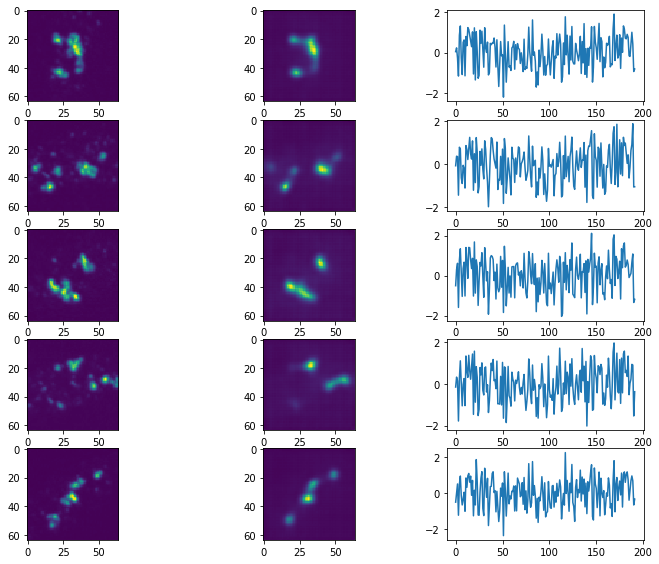

In [111]:
vv = utils.getWell(mmdict,
                    df, width, 4, 5, nchannels, channels=channels)


xhe = sess.run(enc, feed_dict={images:vv})
xdd = sess.run(sdd, feed_dict={enc:xhe})
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[i,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.imshow(xdd[i,:,:,0])
    plt.subplot(20,3,i*3 + 3)
    plt.plot(xhe[i])

In [112]:
# dv = {0:(3,4), 1:(4,3), 2:(6,7), 3:(7,13), 4:(7, 2), 5:(8,3), 6:(12,4), 7:(9,5)}
dv = {0:(12,4), 1:(9,5), 2:(11,8), 3:(2,19), 4:(13,13), 5:(13,8), 6:(4,4)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = utils.getWell(mmdict,df, width, r, cm, nchannels, channels=[2])
    except:
        print("Oh no!!")
        continue
    hek = sess.run(enc, feed_dict={images:k})
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

perm = np.random.permutation(len(colors))
g = g[perm]
colors = colors[perm]
    

12 4
12 4 (90, 192) (90, 192)
9 5
9 5 (90, 192) (664, 192)
11 8
11 8 (754, 192) (133, 192)
2 19
2 19 (887, 192) (65, 192)
13 13
13 13 (952, 192) (369, 192)
13 8
13 8 (1321, 192) (240, 192)
4 4
4 4 (1561, 192) (360, 192)


In [113]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (.5, .5, .5),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.] 8


(1921, 14)
[ 0.24320477  0.07766935  0.05817011  0.05445332  0.04728085  0.04554232
  0.03165682  0.02831591  0.02684953  0.02421872  0.02331743  0.02120212
  0.02023726  0.01943463]
[ 15.96487427   5.09850788   3.81850433   3.57452035   3.10369229
   2.98956895   2.07807231   1.85876274   1.76250386   1.58980775
   1.53064382   1.39178681   1.32844961   1.2757622 ]
(14, 192)
51
117


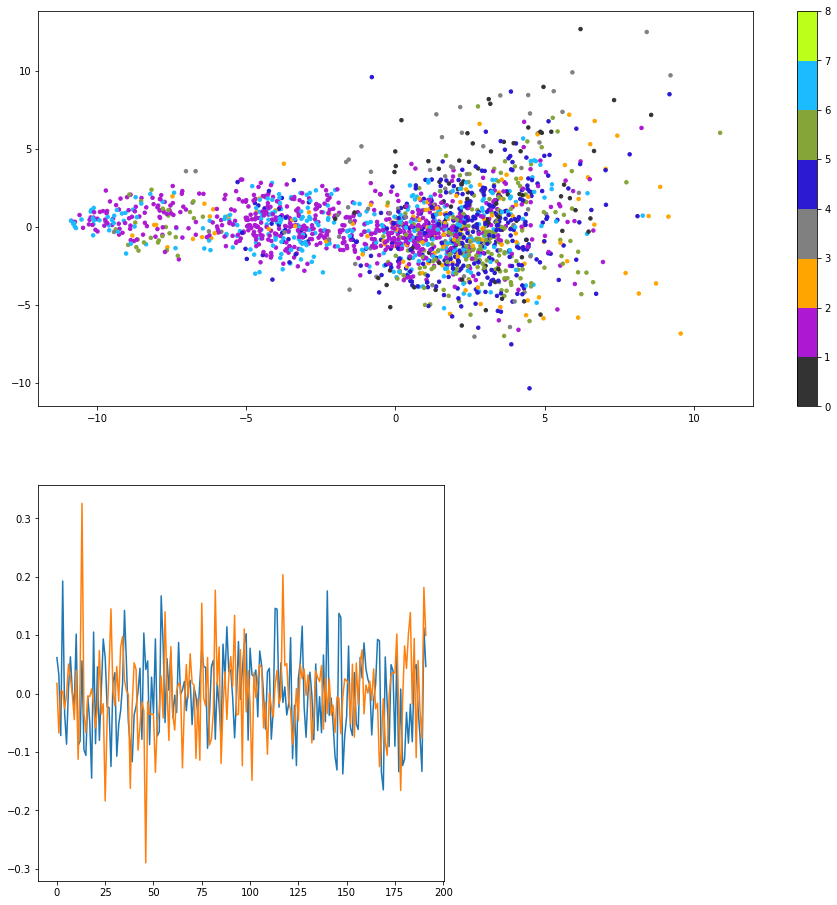

In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=14, whiten=False)
gfit = pca.fit_transform(g)
print(gfit.shape)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.components_.shape)

print(np.argmin(pca.mean_))
print(np.argmax(pca.mean_))
sz = 12
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(211)
sc = ax.scatter(gfit[:,0], gfit[:,1], s=sz, c=colors, cmap=mycmap, norm=norm)
plt.colorbar(sc, cmap=mycmap, norm=norm, spacing='proportional', ticks=bounds,boundaries=bounds)
#sc = ax.scatter(gfit[:,0], gfit[:,1], s=sz, c=colors,cmap="jet")
# plt.colorbar(sc)
ax2 = fig.add_subplot(223)
ppp = ax2.plot(pca.components_[0])
ppp = ax2.plot(pca.components_[1])

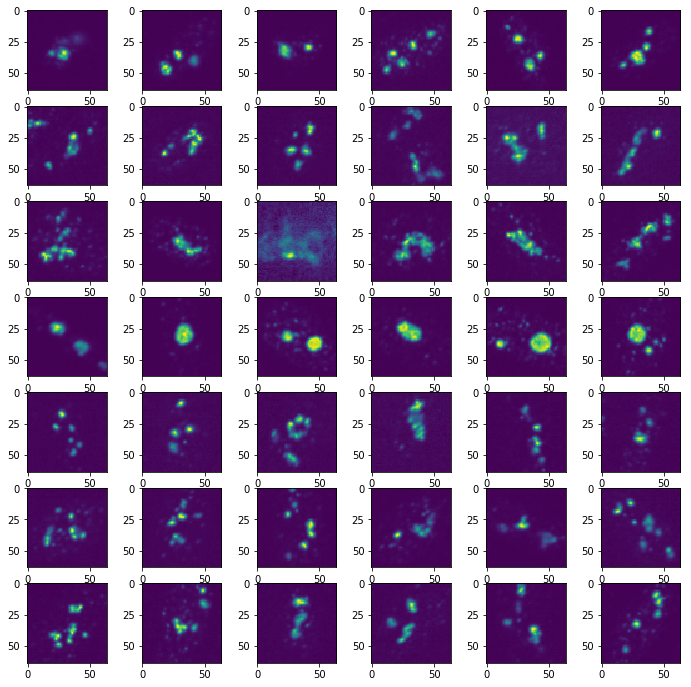

In [115]:
plt.figure(figsize=(12, 12))
for m in dimages.keys():
    h = len(dimages)
    for i in range(6):
        plt.subplot(len(dimages),6, 6*m + i + 1)
        plt.imshow(dimages[m][i+ 40,:,:,0])

(1921, 192)
12 9 (11, 8)
(133, 64, 64, 1) (133, 64, 64, 1)
/Volumes/projects/cjw/Chris/Remark/2017_10_28/images/decoded_12_9.png


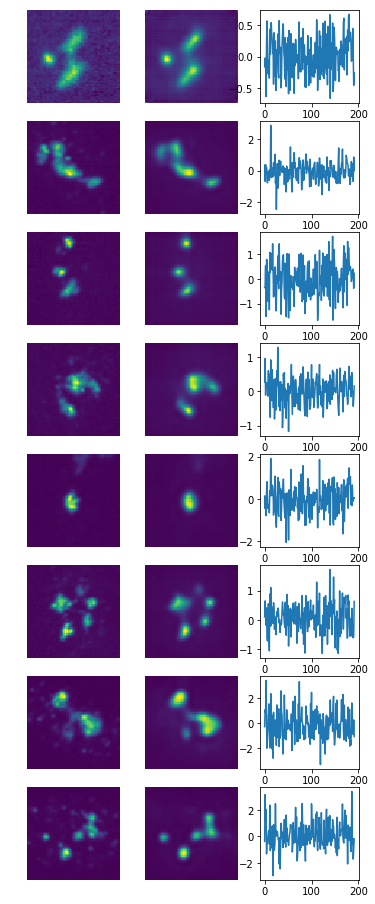

In [116]:
print(g.shape)
plt.figure(figsize=(12, 8))

wc = dv[2]

rwc = wc[0] + 1
cwc = wc[1] + 1
print(rwc, cwc, wc)
b44 = utils.getWell(mmdict,df, width, rwc, cwc, nchannels, channels=[2])
ahe, dec2 = sess.run([enc, sdd], feed_dict={images:b44})

print(b44.shape, dec2.shape)
f44 = plt.figure(figsize=(6,16))
cv = 1
for i in range(8):
    rn = np.random.randint(b44.shape[0])
    plt.subplot(8, 3, cv)
    plt.imshow(b44[rn,:,:,0])
    
    plt.axis("off")
    plt.subplot(8, 3, cv + 1)
    plt.imshow(dec2[rn,:,:,0])
    plt.axis("off")
    plt.subplot(8, 3, cv + 2)
    plt.plot(ahe[rn, :])
    plt.axis("on")
    cv += 3
    
sf = "/Volumes/projects/cjw/Chris/Remark/2017_10_28/images/decoded_{}_{}.png".format(rwc, cwc)
print(sf)
plt.savefig(sf)

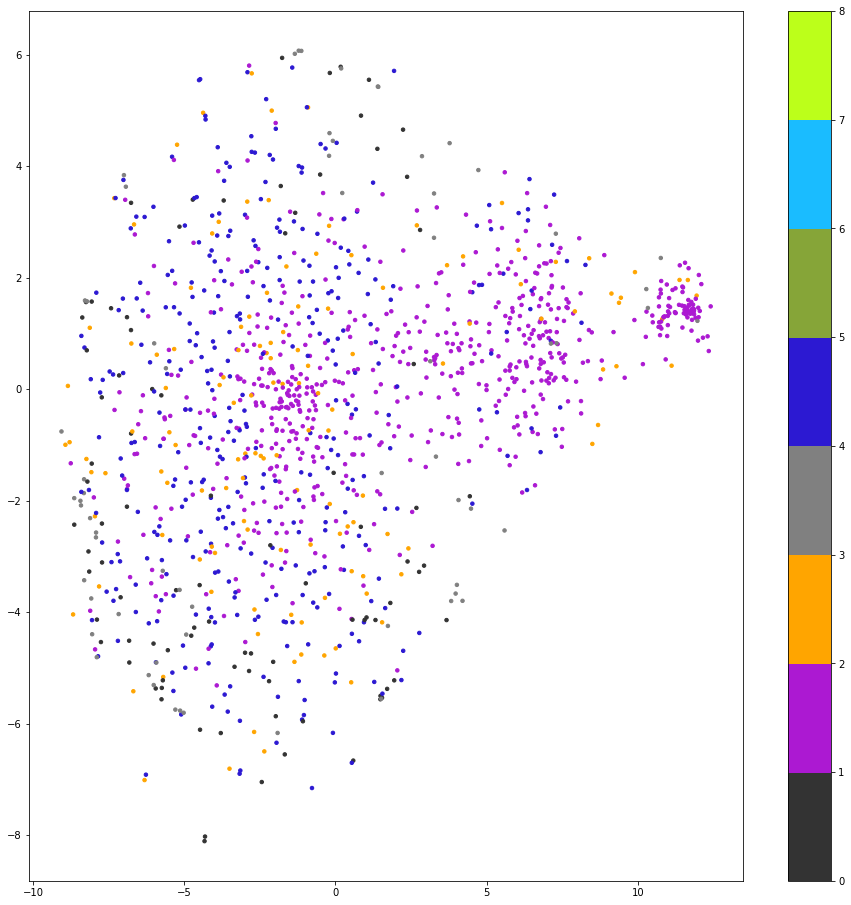

In [91]:
from sklearn.manifold import TSNE
g_emb = TSNE(n_components=2,perplexity=100, learning_rate=40, init='pca').fit_transform(g.astype(np.float64))
g_emb.shape

from mpl_toolkits.mplot3d import Axes3D
sz = 12
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
sc = ax.scatter(g_emb[:,0], g_emb[:,1], s=sz, c=colors, cmap=mycmap, norm=norm)
plt.colorbar(sc, cmap=mycmap, norm=norm, spacing='proportional', ticks=bounds,boundaries=bounds)
# plt.savefig("/Volumes/projects/cjw/Chris/Remark/2017_10_28/images/tsne_002.png")